### Criador: Eduardo Bezerra Robalinho Dantas da Gama, CIVIL T-25

#### Espero que a exposição dos métodos abaixo ajude nos próximos desafios técnicos de ML, há uma breve descrição do que cada bloco faz, no geral, se você passou em ces-11 você entende o que cada bloco faz. Os modelos de ML são estão uma breve explicação do que cada um faz, vendo qual lhe interessa, jogue ele no google que pode achar diversas explicações mais completas

### Impotando as bibliotecas utilizadas 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl as opx
import scipy.optimize as scy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real, Categorical, Integer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

2023-12-03 16:01:04.768097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 16:01:05.102249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 16:01:05.105266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 16:01:06.921323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Importando o relatório fornecido

#### Veja que a aba selecionada foi "P_Tracao" caso seja selecionada outra aba, faz necessário que mude o valor de alguns filtros e o nome da coluna que deseja-se fazer um predição, recomenda-se atenção 

In [2]:
df=pd.read_excel(r'anonymizedData.xlsx','P_Tracao')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Achar quantidade de na por coluna

In [3]:
v=[]
for col in df.columns:
    v.append(df[col].isna().sum())

### Filtrar as colunas que possuam 700 ou menos termos Nan


#### A ideia desse filtro é tirar as colunas que tenham muito Nan, tendo em vista que a falta de dados corrompe uma boa precisão do modelo com a realidade

In [4]:
v=pd.DataFrame(v).reset_index()
w=v[v[0]<700]['index']

df=df.iloc[:,w]

### Filtrar as colunas que possuam estabilidade menor que 400 termos na coluna


#### A ideia desse filtro é tirar as colunas que tenham muitos valores repetidos, a repetição dos valores faz com que seja menor o espaço de busca da variável em busca de predizer um resultado final

In [5]:
r=[]
for col in df.columns:
    r.append(len(df[col].value_counts()))
r=pd.DataFrame(r).reset_index()
w=r[(r[0]>400)]
w=w._append(r.iloc[-1]).index

df=df.iloc[:,w]

### Retirar as linhas que tem muitos Nan

#### A ideia desse filtro é tirar as linhas que tenham muito Nan, a ordem desse filtro importa, tendo em vista que há mais linhas que colunas, logo convém eliminar primeiro as colunas incovenientes para depois filtrar as linhas que realmente importam

In [6]:
S = df.drop('P_Tracao',axis=1)
r=[]
for index in df.index:
    r.append(len(S.loc[index,:].value_counts()))

r=pd.DataFrame(r).reset_index()
w=r[(r[0]>0.75*len(df.columns))]

df=df.iloc[w['index'],:]

### Preencher Nan com zeros

#### A ideia dessa etapa é interpolar no lgar dos Nan, os valores de outras linhas que tenham alguma correlação com a linha que tem Nan, apesar desse método aumentar a correlação das linhas, é uma boa forma de eliminar os Nan.


In [7]:
df=df.interpolate()
### A primeira linha que tenha Nan, não consegue ser interpolada (não há linha acima) logo precisa ser preenchida com 0
df=df.fillna(0)

### Criação de matriz de correlação

#### Construção da matriz de correlação das colunas, permitindo ver se existe colunas muito semelhantes

Text(0.5, 1.0, 'Correlation Heatmap')

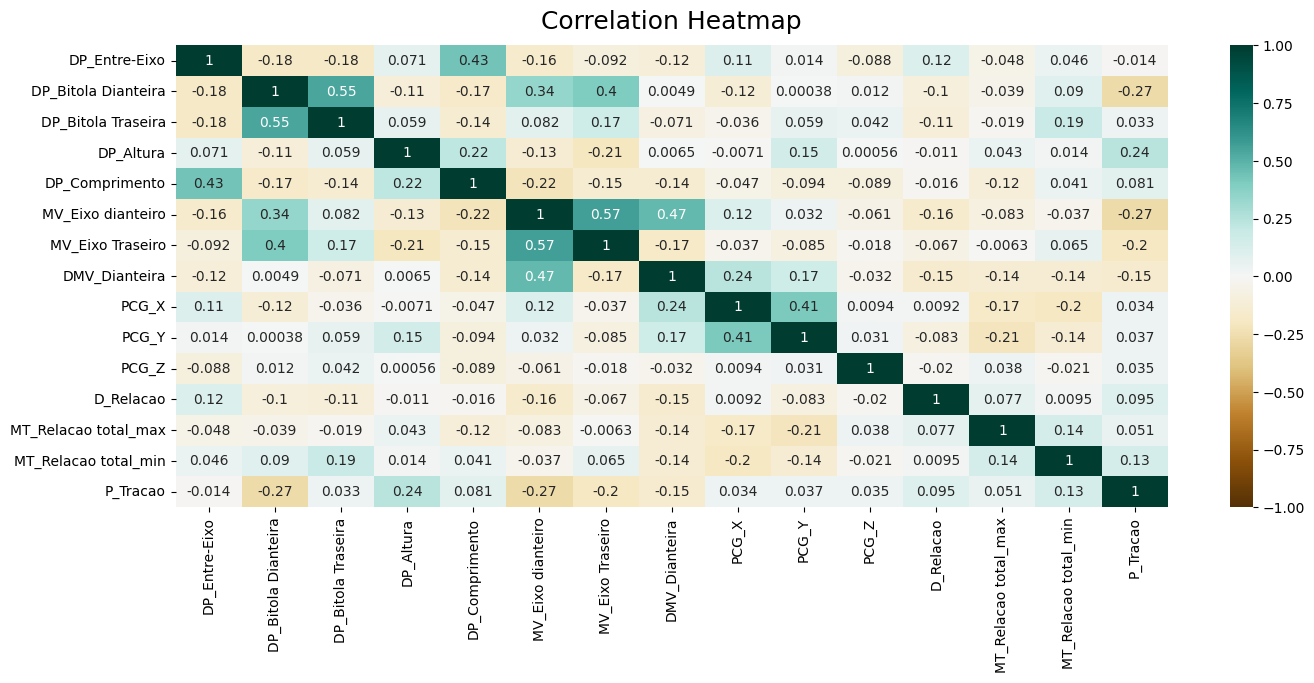

In [8]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped


### Eliminando colunas com mais de 50% de correlação

#### A ideia desse filtro é tirar as colunas que tenham correlação relativamente alta, para não buscar valores em duas colunas muito semelhantes

In [9]:
# Create correlation matrix
corr = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

df.corr()

DP_Entre-Eixo  DP_Bitola Dianteira  DP_Altura  \
DP_Entre-Eixo              1.000000            -0.183995   0.071041   
DP_Bitola Dianteira       -0.183995             1.000000  -0.112348   
DP_Altura                  0.071041            -0.112348   1.000000   
DP_Comprimento             0.430686            -0.167625   0.218857   
MV_Eixo dianteiro         -0.159658             0.340962  -0.134552   
DMV_Dianteira             -0.115254             0.004853   0.006494   
PCG_X                      0.105057            -0.121046  -0.007114   
PCG_Y                      0.014492             0.000384   0.153659   
PCG_Z                     -0.087690             0.011605   0.000558   
D_Relacao                  0.115462            -0.101329  -0.011349   
MT_Relacao total_max      -0.048401            -0.039246   0.042834   
MT_Relacao total_min       0.045716             0.090168   0.013602   
P_Tracao                  -0.013585            -0.269991   0.240891   

                      DP_Comprimento  MV_Eixo dianteiro  DMV_Dianteira  \
DP_Entre-Eixo               0.430686          -0.159658      -0.115254   
DP_Bitola Dianteira        -0.167625           0.340962       0.004853   
DP_Altura                   0.218857          -0.134552       0.006494   
DP_Comprimento              1.000000          -0.220799      -0.142759   
MV_Eixo dianteiro          -0.220799           1.000000       0.471776   
DMV_Dianteira              -0.142759           0.471776       1.000000   
PCG_X                      -0.047010           0.116529       0.242028   
PCG_Y                      -0.093569           0.032422       0.165459   
PCG_Z                      -0.089348          -0.060868      -0.032357   
D_Relacao                  -0.015794          -0.158191      -0.152783   
MT_Relacao total_max       -0.115280          -0.082796      -0.139919   
MT_Relacao total_min        0.041415          -0.036933      -0.139530   
P_Tracao                    0.080938          -0.272267      -0.152138   

                         PCG_X     PCG_Y     PCG_Z  D_Relacao  \
DP_Entre-Eixo         0.105057  0.014492 -0.087690   0.115462   
DP_Bitola Dianteira  -0.121046  0.000384  0.011605  -0.101329   
DP_Altura            -0.007114  0.153659  0.000558  -0.011349   
DP_Comprimento       -0.047010 -0.093569 -0.089348  -0.015794   
MV_Eixo dianteiro     0.116529  0.032422 -0.060868  -0.158191   
DMV_Dianteira         0.242028  0.165459 -0.032357  -0.152783   
PCG_X                 1.000000  0.411378  0.009390   0.009186   
PCG_Y                 0.411378  1.000000  0.030738  -0.083463   
PCG_Z                 0.009390  0.030738  1.000000  -0.019662   
D_Relacao             0.009186 -0.083463 -0.019662   1.000000   
MT_Relacao total_max -0.172956 -0.211716  0.038045   0.076766   
MT_Relacao total_min -0.196536 -0.138858 -0.021220   0.009508   
P_Tracao              0.033811  0.037435  0.035097   0.094957   

                      MT_Relacao total_max  MT_Relacao total_min  P_Tracao  
DP_Entre-Eixo                    -0.048401              0.045716 -0.013585  
DP_Bitola Dianteira              -0.039246              0.090168 -0.269991  
DP_Altura                         0.042834              0.013602  0.240891  
DP_Comprimento                   -0.115280              0.041415  0.080938  
MV_Eixo dianteiro                -0.082796             -0.036933 -0.272267  
DMV_Dianteira                    -0.139919             -0.139530 -0.152138  
PCG_X                            -0.172956             -0.196536  0.033811  
PCG_Y                            -0.211716             -0.138858  0.037435  
PCG_Z                             0.038045             -0.021220  0.035097  
D_Relacao                         0.076766              0.009508  0.094957  
MT_Relacao total_max              1.000000              0.138023  0.051253  
MT_Relacao total_min              0.138023              1.000000  0.134924  
P_Tracao                          0.051253              0.134924  1.000000

### Criação de matriz de correlação filtrada

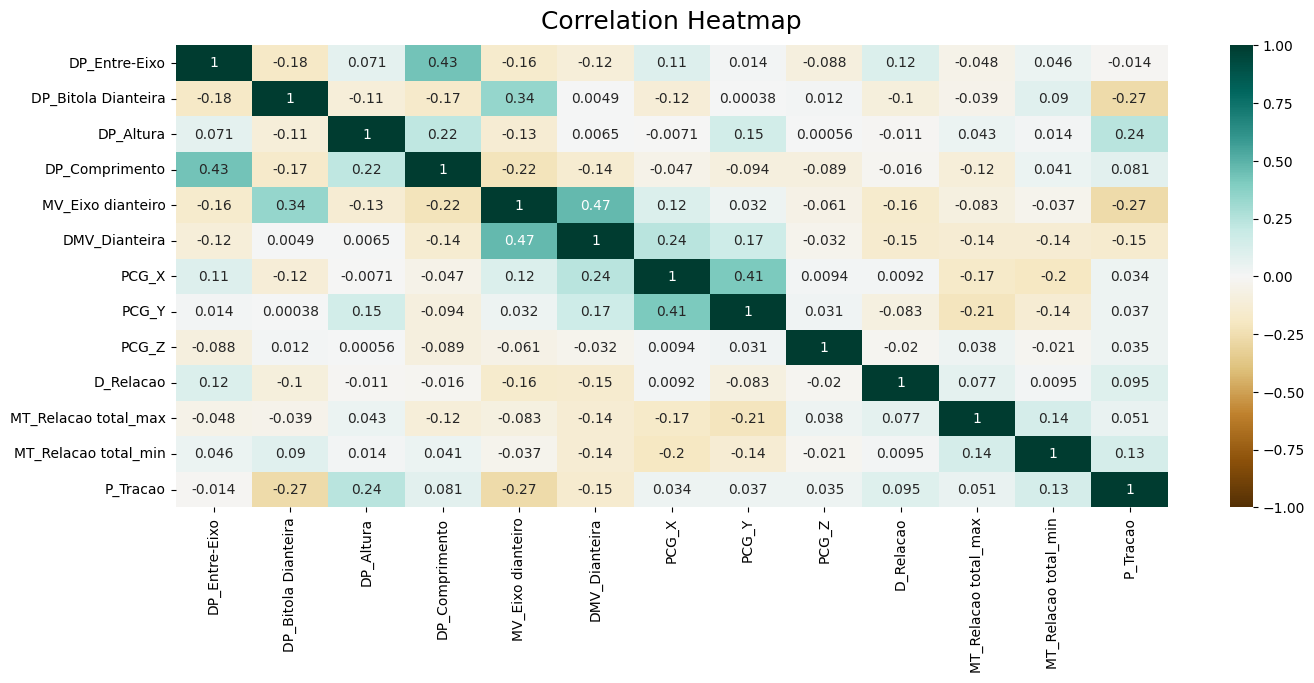

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped

### Criação de gráficos que relacionam a distribuição de pontos das diversas colunas (permite uma visão geral de todos os dados que de fato ficaram após o tratamento)

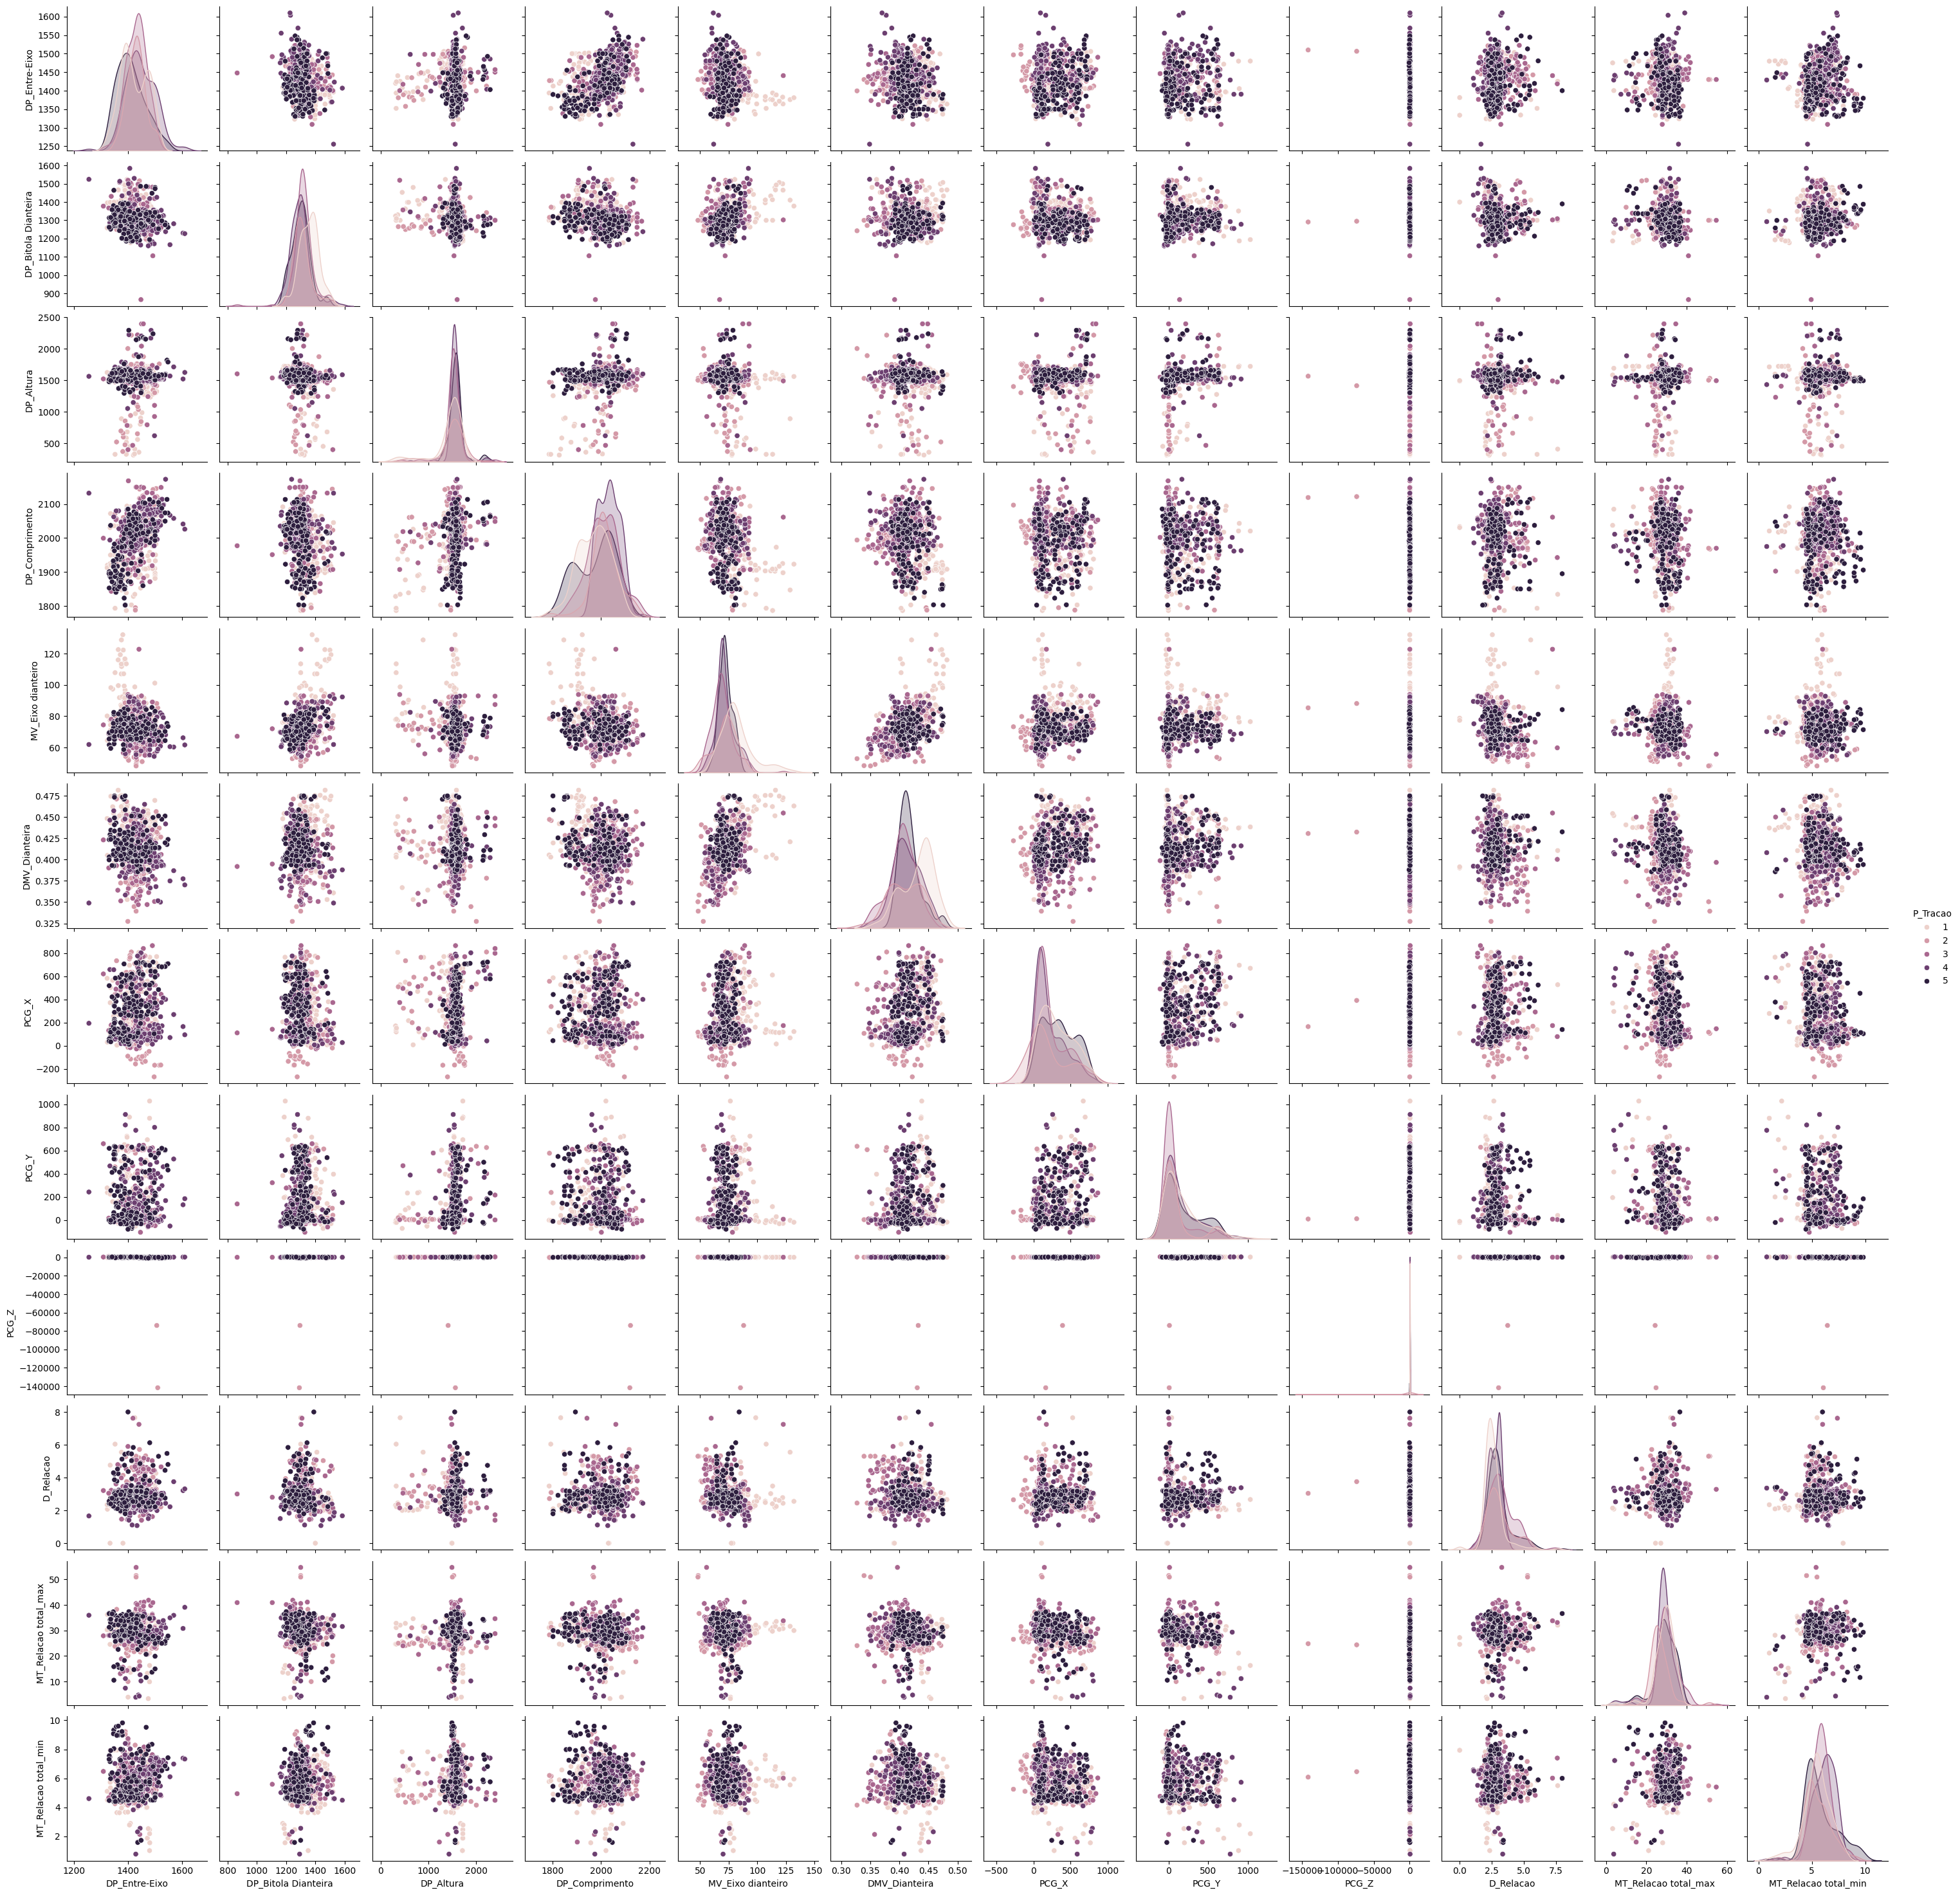

In [11]:
sns.pairplot(df,hue='P_Tracao')

### Modelo de regressão logística

#### A ideia do modelo é usar regressão linear para tentar prever o resultado de classificação, é um modelo famoso para o assunto, porém, alcançou baixa precisão

In [12]:
X = df.drop(['P_Tracao'],axis=1)
y = df['P_Tracao']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [14]:
logistic_regression= LogisticRegression(solver='liblinear',max_iter=100000)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

<Axes: xlabel='Predicted', ylabel='Actual'>

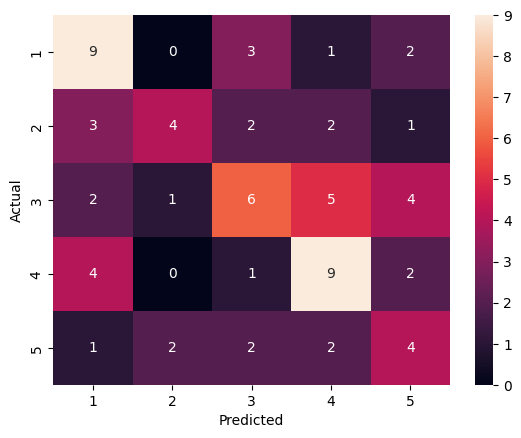

In [15]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [16]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.4444444444444444


### Modelo usando reder neural KERAS


#### Esse modelo é uma rede neural para tentar predizer os resultados e classificar as linhas. Modelo muito forte, porém requer que busque-se corretamente o número de camadas e o número de neurônios por camada. Recomendo, antes de usar esse modelo, um gagá de leve sobre como funciona (basicão mesmo) uma rede neural. É uma ferramenta pesada, mas requer cautela

In [17]:
# Ajustar os rótulos para começar de 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Número de classes
num_classes = 5

# Criar o modelo de regressão logística multiclasse com o Keras
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))  # Camada oculta 1
model.add(Dense(32, activation='relu'))  # Camada oculta 2
model.add(Dense(num_classes, input_dim=7, activation='softmax'))


# Compilar o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train_adjusted, epochs=50, batch_size=32, validation_split=0.4)


# Fazer previsões no conjunto de teste
y_pred = np.argmax(model.predict(X_test), axis=1) + 1 

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

Epoch 1/50
12/12 [==============================] - 1s 29ms/step - loss: 149.4664 - accuracy: 0.2396 - val_loss: 238.5603 - val_accuracy: 0.3398
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 56.0098 - accuracy: 0.2812 - val_loss: 187.8047 - val_accuracy: 0.3047
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 29.7478 - accuracy: 0.3047 - val_loss: 194.9331 - val_accuracy: 0.3320
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 22.1962 - accuracy: 0.3229 - val_loss: 196.9812 - val_accuracy: 0.3750
Epoch 5/50
12/12 [==============================] - 0s 11ms/step - loss: 17.4691 - accuracy: 0.3750 - val_loss: 198.9899 - val_accuracy: 0.3438
Epoch 6/50
12/12 [==============================] - 0s 10ms/step - loss: 17.1552 - accuracy: 0.3438 - val_loss: 190.9808 - val_accuracy: 0.3633
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 16.4328 - accuracy: 0.3672 - val_loss: 184.9931 - val_accuracy: 0

### Clustering

#### Modelo não supervisionado, isto é, não se precisa que se saiba de antemão quais os resultados que o modelo deve tentar obter. Em algumas situações pode ser conveninete utilizar, mas para a disposião do problema em questão não obteve resultados satisfatórios.

In [18]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#Aplique K-Means clustering
num_clusters = 5  # pois você tem 5 classes
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train)

# Obtenha rótulos de cluster para os dados de treinamento
y_train_clusters = kmeans.predict(X_train)

# Obtenha rótulos de cluster para os dados de teste
y_test_clusters = kmeans.predict(X_test)

# Avalie a precisão do clustering usando a correspondência de rótulos com as classes reais
accuracy_train = accuracy_score(y_train, y_train_clusters)
accuracy_test = accuracy_score(y_test, y_test_clusters)

print(f'Acurácia no conjunto de treinamento: {accuracy_train*1000}%')
print(f'Acurácia no conjunto de teste: {accuracy_test*100}%')

Acurácia no conjunto de treinamento: 166.66666666666666%
Acurácia no conjunto de teste: 15.887850467289718%


/home/eduardo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### GMM metodo

#### métodos estatístico para predizer variáveis do problema, não alcançou resultados satisfatórios

In [19]:
# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar GMM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Número de clusters (n_components) deve ser o número de classes
n_components = 5

# Crie o modelo GMM
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Treine o modelo no conjunto de treinamento
gmm.fit(X_train_scaled)

# Obtenha rótulos de cluster para os dados de treinamento e teste
y_train_pred = gmm.predict(X_train_scaled)
y_test_pred = gmm.predict(X_test_scaled)

# Avalie a precisão do clustering usando a correspondência de rótulos com as classes reais
accuracy_train = accuracy_score(y_train, y_train_pred + 1)  # Adiciona 1 para reverter o ajuste
accuracy_test = accuracy_score(y_test, y_test_pred + 1)  # Adiciona 1 para reverter o ajuste

print(f'Acurácia no conjunto de treinamento: {accuracy_train*100}%')
print(f'Acurácia no conjunto de teste: {accuracy_test*100}%')


Acurácia no conjunto de treinamento: 13.654618473895583%
Acurácia no conjunto de teste: 12.616822429906541%


### Randon Forest

#### Método das fllorestas aleatórias (combinação de diversas árvores de decisão), variando o número de estimadores consegue-se resultados fenomenais para predição dos resultados do problema de predição. Há diversos hiperparâmetros que convenham a ser avaliados a depender do problema, no geral é um método de fácil implementação que alcança resultados interesantes.

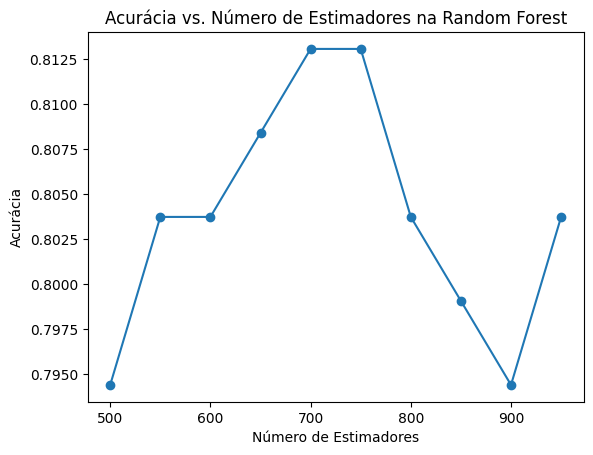

In [20]:
#Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Varie o número de estimadores
num_estimators_range = range(500,1000,50)
accuracy_scores = []

for num_estimators in num_estimators_range:
    # Crie o modelo de Random Forest com o número atual de estimadores
    model = RandomForestClassifier(n_estimators=num_estimators, random_state=42,max_depth=2000,criterion='entropy')

    # Treine o modelo no conjunto de treinamento
    model.fit(X_train_scaled, y_train)

    # Faça previsões no conjunto de teste
    y_pred = model.predict(X_test_scaled)

    # Avalie a precisão do modelo e armazene
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)


# Plote a relação entre o número de estimadores e a acurácia
plt.plot(num_estimators_range, accuracy_scores, marker='o')
plt.title('Acurácia vs. Número de Estimadores na Random Forest')
plt.xlabel('Número de Estimadores')
plt.ylabel('Acurácia')
plt.show()

#### Utilização do resultado de validação cruzada para verificar se houve overfitting nos resultados, é uma boa prática após a aplicação do modelo, a fim de verificar se são realista os resultados alcançados

In [21]:
# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crie o modelo Random Forest
model = RandomForestClassifier(n_estimators=800, random_state=42,max_depth=2000,criterion='entropy')

# Realize a validação cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=20)  # cv é o número de dobras na validação cruzada

# Imprima os scores de validação cruzada
print("Scores de Validação Cruzada:", cv_scores)
print("Acurácia Média: {:.2f}%".format(np.mean(cv_scores) * 100))

Scores de Validação Cruzada: [0.88 0.76 0.92 1.   0.76 0.76 0.84 0.88 0.72 0.84 0.76 0.8  0.76 0.8
 0.76 0.76 0.84 0.84 0.75 0.75]
Acurácia Média: 80.90%


### XGBoost

#### Método numérico que é a junção de diversos métodos de machine learning a fim de alcançar o melhor resultado possível. Caso bem empregado, resolve praticamente tudo, porém requer atenção nos hiperparâmetos devido a sensibilidade dos mesmos

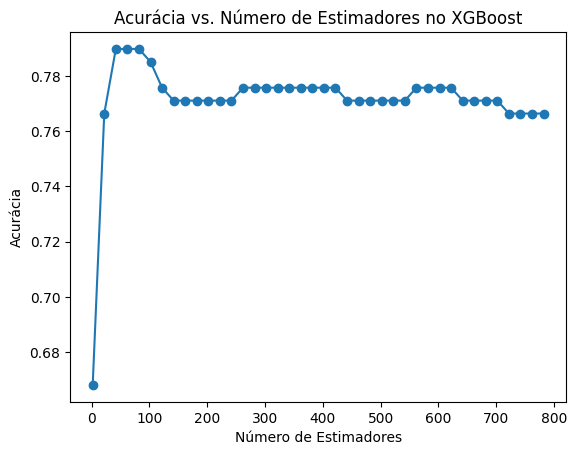

In [22]:
# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y-1, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Varie o número de estimadores
num_estimators_range = range(2,800,20)
accuracy_scores = []

for num_estimators in num_estimators_range:
    # Crie o modelo XGBoost com o número atual de estimadores
    model = XGBClassifier(n_estimators=num_estimators, random_state=42)

    # Treine o modelo no conjunto de treinamento
    model.fit(X_train_scaled, y_train)

    # Faça previsões no conjunto de teste
    y_pred = model.predict(X_test_scaled)

    # Avalie a precisão do modelo e armazene
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plote a relação entre o número de estimadores e a acurácia
plt.plot(num_estimators_range, accuracy_scores, marker='o')
plt.title('Acurácia vs. Número de Estimadores no XGBoost')
plt.xlabel('Número de Estimadores')
plt.ylabel('Acurácia')
plt.show()


### KNN

#### Famoso algoritmo de "K-Nearest Neighbors", também é um algoritimo de busca supervisionado. No geral, alcaçou resultados próximos do Random Forest e XGBoost

In [23]:

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y-1, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crie o modelo KNN
model = KNeighborsClassifier(n_neighbors=1)  # você pode ajustar o número de vizinhos (k) conforme necessário

# Treine o modelo no conjunto de treinamento
model.fit(X_train_scaled, y_train)

# Faça previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avalie a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia do KNN: {accuracy*100}%')

Acurácia do KNN: 76.63551401869158%


### Otimização baysiana

#### Método de otimização que busca os melhores valores para os hiperparâmetros. Vale a pena colocar um longo range de busca e botar pra rodar, demora mas acha, quase sempre, a melhor combinação. Convém bem mais do que ficar testando os hiperparâmetros na mão

In [24]:
# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar otimização bayesiana)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defina os espaços de busca para os hiperparâmetros
param_space = {
    'n_estimators': Integer(500, 700),
    'max_depth': Integer(900, 1000),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion' : Categorical(['entropy','gini'])
}

# Crie o modelo de Random Forest
rf_model = RandomForestClassifier()

# Inicialize a busca bayesiana
opt = BayesSearchCV(
    rf_model,
    param_space,
    n_iter=50,  # Número de iterações da busca
    n_jobs=-1,
    cv=5,  # Número de dobras na validação cruzada
    random_state=42,
)

# Execute a otimização
opt.fit(X_train_scaled, y_train)

# Imprima os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(opt.best_params_)

# Avalie o modelo otimizado
y_pred = opt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo otimizado: {accuracy*100}%')


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Melhores Hiperparâmetros:
OrderedDict([('criterion', 'gini'), ('max_depth', 900), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 700)])
Acurácia do modelo otimizado: 0.8888888888888888
